In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F
import scipy.stats
from scipy.stats import binom
from matplotlib import pyplot as plt

In [3]:
from mstcn_model import *
from utility.adaptive_data_loader import Breakfast, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='2'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=8,
    learning_rate=5e-4,
    weight_decay=0,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=1,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=3,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-mstcn-weaksup-split3/",
    project_name="breakfast-split-3",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

train_split_file_list = set(open(config.train_split_file).read().split("\n")[0:-1])
print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 8, 'learning_rate': 0.0005, 'weight_decay': 0, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 1, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 3, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-mstcn-weaksup-split3/', 'project_name': 'breakfast-split-3', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split3.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split3.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised_split': 

In [7]:
traindataset = Breakfast(config, fold='train', fold_file_name=config.train_split_file)
testdataset = Breakfast(config, fold='test', fold_file_name=config.test_split_file)

Number of videos logged in train fold is 1279
Number of videos not found in train fold is 0
Number of videos logged in test fold is 433
Number of videos not found in test fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=4, 
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)
testloader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=config.batch_size, 
                                          shuffle=False,
                                          pin_memory=True, num_workers=4,
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)

In [9]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [10]:
loaded_vidid_selected_frames = np.load("/home/dipika16/ar/TimestampActionSeg/data/breakfast_annotation_all.npy", 
                                       allow_pickle=True).item()

video_id_boundary_frames = pickle.load(open("data/breakfast_boundary_annotations.pkl", "rb"))
video_id_boundary_frames = dict([(key[:-4], val) for key,val in video_id_boundary_frames.items()])

weak_labels = pickle.load(open('data/breakfast_weaklysupervised_labels.pkl', 'rb'))
weak_labels = dict([(key[:-4], val) for key,val in weak_labels.items()])

loaded_mean_var_actions = pickle.load(open("data/breakfast_meanvar_actions.pkl", "rb"))

with open('/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/len_video.txt', 'r') as openf:
    attributes = [item.strip().split()[::-1] for item in openf.readlines()]
frame_id_dict = dict([(vidid[:-4], int(framecount)) for vidid,framecount in attributes])

df=pd.read_csv(config.label_id_csv)
label_id_to_label_name = {}
label_name_to_label_id_dict = {}
for i, ele in df.iterrows():
    label_id_to_label_name[ele.label_id] = ele.label_name
    label_name_to_label_id_dict[ele.label_name] = ele.label_id

In [11]:
# weak_labels, loaded_mean_var_actions

In [12]:
posterior_table = {}
prior_table = {}

In [13]:
# pickle.dump(prior_table, open('data/breakfast_lengthmodel_multinomial_prior.pkl', 'wb'))

In [14]:
# for ele in weak_labels.keys():
#     frame_count = frame_id_dict[ele]
#     label_list = weak_labels[ele]
#     mean_list = np.array([loaded_mean_var_actions[label][0] for label in label_list])
#     total_mean = np.sum(mean_list)
#     left_sum = np.cumsum(mean_list)
#     relative_sum = left_sum / total_mean
#     prob_id_ge_boundary = [binom.cdf(np.arange(frame_count)+1, frame_count, rel) for rel in relative_sum]
#     prob_id_gt_boundary = [1] + [cdf - binom.pmf(np.arange(frame_count)+1, 
#                                                  frame_count,
#                                                  rel) for rel,cdf in zip(relative_sum, prob_id_ge_boundary)]
#     prob_id_gt_boundary[-1] = 0
#     prior_table[ele] = np.stack([prob_id_gt_boundary[j-1] - prob_id_gt_boundary[j] 
#                                     for j in range(1,len(label_list)+1)], axis=0)

prior_table = pickle.load(open('data/breakfast_lengthmodel_multinomial_prior.pkl', 'rb'))

In [15]:
def generate_posterior_loss_weights(framewise_proba, ele):
    '''
    ele is video_id
    '''
    global posterior_table
    frame_count = frame_id_dict[ele]
    label_list = [label_name_to_label_id_dict[item] for item in weak_labels[ele]]
    seqlen = len(label_list)
    label_seq_prob = framewise_proba[:frame_count,label_list]
    label_seq_logprob = torch.log(label_seq_prob + 1e-10)

    left_probsum = torch.cumsum(label_seq_prob, dim=1)
    right_probsum = torch.sum(label_seq_prob, dim=1, keepdim=True) - torch.cumsum(label_seq_prob, dim=1) + label_seq_prob

    left_logprobsum = torch.log(torch.clip(left_probsum, min=1e-20))
    right_logprobsum = torch.log(torch.clip(right_probsum, min=1e-20))

    left_logprobsum_left_idsum = torch.cumsum(left_logprobsum, dim=0)
    left_logprobsum_left_idsum -= left_logprobsum
    right_logprobsum_right_idsum = torch.sum(right_logprobsum, dim=0, keepdim=True) - torch.cumsum(right_logprobsum, dim=0)

    for k in range(seqlen):
        left_logprobsum_left_idsum[:k,k] = -1000
        remaining_labelcount = seqlen-k-1
        if remaining_labelcount > 0:
            right_logprobsum_right_idsum[-remaining_labelcount:,k] = -1000

    loglikelihood = label_seq_logprob + 1*(left_logprobsum_left_idsum + right_logprobsum_right_idsum)/(frame_count)
    posterior = loglikelihood.T + torch.log(torch.clip(torch.tensor(prior_table[ele]), min=1e-10))/20
    posterior = torch.softmax(posterior/2, dim=0)
    posterior_table[ele] = posterior

P26_cam02_P26_scrambledegg


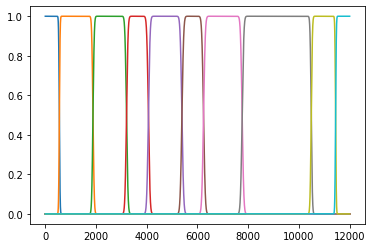

In [16]:
frame_count = 12000
ele = list(weak_labels.keys())[0]
print(ele)
label_list = weak_labels[ele]
mean_list = np.array([loaded_mean_var_actions[label][0] for label in label_list])
total_mean = np.sum(mean_list)
left_sum = np.cumsum(mean_list)
relative_sum = left_sum/total_mean
prob_id_ge_boundary = [binom.cdf(np.arange(frame_count)+1, frame_count, rel) for rel in relative_sum]
prob_id_gt_boundary = [1] + [cdf - binom.pmf(np.arange(frame_count)+1, 
                                             frame_count,
                                             rel) for rel,cdf in zip(relative_sum, prob_id_ge_boundary)]
prob_id_gt_boundary[-1] = 0
priors = np.stack([prob_id_gt_boundary[j-1] - prob_id_gt_boundary[j] 
                                for j in range(1,len(label_list)+1)], axis=0)
priors = np.stack([priors, prob_id_ge_boundary], axis=0)

for prior in priors[0]:
    plt.plot(np.arange(12000), prior)

In [17]:
frame_count = 12000
ele = list(weak_labels.keys())[0]
print(ele)
boundary_probs = []
label_list = weak_labels[ele]
prob_boundary_le_id = 0

posterior_id_between_boundary = priors[0]

prob_boundary_le_id = 1 - np.cumsum(posterior_id_between_boundary, axis=0)
prob_boundary_le_id = np.concatenate([np.zeros((len(label_list), 1)), prob_boundary_le_id], axis=1)
frame_wise_proba = prob_boundary_le_id[:,1:] - prob_boundary_le_id[:,:-1]

P26_cam02_P26_scrambledegg


array([  554.75554893,  1880.83252272,  3202.22802753,  4065.98680987,
        5387.38231468,  6239.2061267 ,  7761.70125547, 10485.46502497,
       11445.24445107,     0.        ])

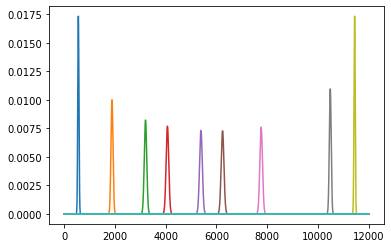

In [18]:
for proba in frame_wise_proba:
    plt.plot(np.arange(12000), proba)

np.sum(frame_wise_proba * np.arange(frame_count), axis=1)

In [19]:
def get_estimated_boundaries():
    estimated_boundary_dict = {}
    for ele in weak_labels.keys():
        if (ele + ".txt") not in train_split_file_list:
            continue
        else:
            frame_count = frame_id_dict[ele]
            label_list = [label_name_to_label_id_dict[item] for item in weak_labels[ele]]
            posterior_id_between_boundary = posterior_table[ele]

            prob_boundary_le_id = 1 - np.cumsum(posterior_id_between_boundary, axis=0)
            prob_boundary_le_id = np.concatenate([np.zeros((len(label_list), 1)), prob_boundary_le_id], axis=1)
            frame_wise_proba = prob_boundary_le_id[:,1:] - prob_boundary_le_id[:,:-1]
#             import pdb
#             pdb.set_trace()
            estimated_boundary_dict[ele] = np.sum(frame_wise_proba * np.arange(frame_count), axis=1)[:-1]
            
    return estimated_boundary_dict

In [20]:
def get_estimated_loss(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global posterior_table
    loss_arr = []
    device = data_feat.device
    for iter_num in range(len(data_count)):
        ele = video_ids[iter_num]
        frame_count = frame_id_dict[ele]
        label_list = [label_name_to_label_id_dict[item] for item in weak_labels[ele]]
        label_list = torch.tensor(label_list).type(torch.long).to(device)
        label_seq_logprob = torch.log(data_feat[iter_num][:frame_count, label_list] + 1e-10)
        weights = posterior_table[ele].to(device).T
        weighted_loss = torch.sum(weights * label_seq_logprob, dim=1)
        loss_arr.append(weighted_loss)
    return -torch.mean(torch.cat(loss_arr)), loss_arr

In [21]:
def get_boundary_err():
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundary_dict = get_estimated_boundaries()
    for ele in video_id_boundary_frames.keys():
        if ele + ".txt" not in train_split_file_list:
            continue
        estimated_boundary_list = estimated_boundary_dict[ele]

        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        if np.isnan(estimated).any():
            print(ele)
        actual = np.array(video_id_boundary_frames[ele][:-1])
        if len(actual) != len(estimated):
            print(ele)
            continue

        mse_err = (actual - estimated)**2
        err_list.append(mse_err)

    print(f"Train Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")

In [22]:
pseudo_labels_dir = "/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/length_segmentation_output/"
def get_single_random(output_p, video_ids):
    # Generate target for only timestamps. Do not generate pseudo labels at first 30 epochs.
    boundary_target_tensor = torch.ones((output_p.shape[0], output_p.shape[2]), dtype=torch.long, 
                                        device=output_p.device) * (-100)
    for iter_num, cur_vidid in enumerate(video_ids):
        pseudo_l = open(pseudo_labels_dir + cur_vidid + ".txt").read().split("\n")[0:-1]
        pseudo_l = [label_name_to_label_id_dict[ele] for ele in pseudo_l]
        abc = torch.tensor(pseudo_l).to(torch.long).to(boundary_target_tensor.device)
        frame_idx_tensor = torch.arange(0, len(pseudo_l), 1).to(device)
        boundary_target_tensor[iter_num, frame_idx_tensor] = abc

    return boundary_target_tensor

In [23]:
set_seed()
model = MultiStageModel(num_stages=4, num_layers=10, num_f_maps=64, dim=2048, num_classes=48).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Requires loaded_vidid_selected_frames, boundaries_dict
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [24]:
loaded_file=torch.load(f"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-lenassum-mstcn-split3-slup15/"
                       f"ms-tcn-initial-25-epochs.wt")
model.load_state_dict(loaded_file)

<All keys matched successfully>

In [25]:
model.eval()
print("Calculating Expectation")
correct = 0.0
total = 0.0

for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        for j in range(len(prob)):
            generate_posterior_loss_weights(prob[j].cpu(), item[4][j])

        if i % 20 == 0:
            print(f"Iter {i}")

get_boundary_err()

print("Calculating Validation Data Accuracy")
correct = 0.0
total = 0.0
for i, item in enumerate(testloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)

        pred = torch.argmax(predictions[-1], dim=1)
        correct += float(torch.sum((pred == item_2) * src_mask).item())
        total += float(torch.sum(src_mask).item())
val_acc = correct * 100.0 / total
print(f"Validation:: Probability Accuracy {val_acc}")

Calculating Expectation
Iter 0
Iter 20
Iter 40
Iter 60
Iter 80
Iter 100
Iter 120
Iter 140
Train Boundary avergage error = 313.391
Calculating Validation Data Accuracy
Validation:: Probability Accuracy 54.776368435444


In [26]:
initialize_epoch = 25
expectation_cal_gap = 5
best_val_acc = 0
for epoch in range(26, 1000):
    print("Starting Training")
    model.train()
    for i, item in enumerate(trainloader):
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
        optimizer.zero_grad()
        
        middle_pred, predictions = model(item_0, src_mask_mse)
        psuedo_l = get_single_random(predictions[-1], item[4])
        
        loss = 0
        for p in predictions:
            if epoch <= initialize_epoch:
                loss += ce_criterion(p, psuedo_l)
                loss += 0.15 * torch.mean(torch.clamp(mse_criterion(F.log_softmax(p[:, :, 1:], dim=1), 
                                                                    F.log_softmax(p.detach()[:, :, :-1], dim=1)), min=0,
                                            max=16) * src_mask_mse[:, :, 1:])
            else:
                prob = torch.softmax(p, dim=1)
                prob = prob.permute(0, 2, 1)
                es_loss, _ = get_estimated_loss(prob, item_1, item[4], item_2)
                loss += es_loss
            
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            with torch.no_grad():
                pred = torch.argmax(predictions[-1], dim=1)
                correct = float(torch.sum((pred == item_2) * src_mask).item())
                total = float(torch.sum(src_mask).item())
                print(f"Training:: Epoch {epoch}, Iteration {i}, Current loss {loss.item()}" +
                      f" Accuracy {correct * 100.0 / total}")
    if epoch == initialize_epoch:
        torch.save(model.state_dict(), config.output_dir + "ms-tcn-initial-15-epochs.wt")
    # Calculating Expectation Step
    model.eval()
    if (epoch >= initialize_epoch) and (epoch % expectation_cal_gap == 0):
        print("Calculating Expectation")
        correct = 0.0
        total = 0.0

        for i, item in enumerate(trainloader):
            with torch.no_grad():
                item_0 = item[0].to(device)
                item_1 = item[1].to(device)
                item_2 = item[2].to(device)
                src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
                src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

                middle_pred, predictions = model(item_0, src_mask_mse)
                prob = torch.softmax(predictions[-1], dim=1)
                prob = prob.permute(0, 2, 1)
                for j in range(len(prob)):
                    generate_posterior_loss_weights(prob[j].cpu(), item[4][j])
                
                if i % 20 == 0:
                    print(f"Epoch {epoch} iter {i}")
                    
        get_boundary_err()

    print("Calculating Validation Data Accuracy")
    correct = 0.0
    total = 0.0
    for i, item in enumerate(testloader):
        with torch.no_grad():
            item_0 = item[0].to(device)
            item_1 = item[1].to(device)
            item_2 = item[2].to(device)
            src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
            src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

            middle_pred, predictions = model(item_0, src_mask_mse)

            pred = torch.argmax(predictions[-1], dim=1)
            correct += float(torch.sum((pred == item_2) * src_mask).item())
            total += float(torch.sum(src_mask).item())
    val_acc = correct * 100.0 / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-best-model-fulllikelihood.wt")
    torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-last-model-fulllikelihood.wt")
    print(f"Validation:: Epoch {epoch}, Probability Accuracy {val_acc}")

Starting Training
Training:: Epoch 26, Iteration 0, Current loss 0.9850942167875645 Accuracy 57.00719159137009
Training:: Epoch 26, Iteration 10, Current loss 0.8089960856907088 Accuracy 59.3910149750416
Training:: Epoch 26, Iteration 20, Current loss 0.7767251430032314 Accuracy 70.0066181336863
Training:: Epoch 26, Iteration 30, Current loss 0.6538714008887425 Accuracy 63.2979696359978
Training:: Epoch 26, Iteration 40, Current loss 0.734196155245455 Accuracy 61.66067795142647
Training:: Epoch 26, Iteration 50, Current loss 0.664328531859349 Accuracy 58.47207769684356
Training:: Epoch 26, Iteration 60, Current loss 0.7020353008407959 Accuracy 62.99831833020081
Training:: Epoch 26, Iteration 70, Current loss 0.6604551867133219 Accuracy 61.09981515711645
Training:: Epoch 26, Iteration 80, Current loss 0.7498601610594046 Accuracy 71.08584484822109
Training:: Epoch 26, Iteration 90, Current loss 0.5888418176372106 Accuracy 59.81019407123054
Training:: Epoch 26, Iteration 100, Current loss

Train Boundary avergage error = 339.572
Calculating Validation Data Accuracy
Validation:: Epoch 30, Probability Accuracy 54.903599868304305
Starting Training
Training:: Epoch 31, Iteration 0, Current loss 1.5939193473405422 Accuracy 65.18334907145105
Training:: Epoch 31, Iteration 10, Current loss 1.2929745536748156 Accuracy 58.65615358244772
Training:: Epoch 31, Iteration 20, Current loss 1.7274923850659456 Accuracy 49.82642061026859
Training:: Epoch 31, Iteration 30, Current loss 1.5718633778006688 Accuracy 68.99991889042096
Training:: Epoch 31, Iteration 40, Current loss 1.407408138792277 Accuracy 53.73406193078324
Training:: Epoch 31, Iteration 50, Current loss 1.2777789411939533 Accuracy 66.80971320912707
Training:: Epoch 31, Iteration 60, Current loss 1.6413635766922263 Accuracy 58.02418862238873
Training:: Epoch 31, Iteration 70, Current loss 1.5231343251043294 Accuracy 61.60412067696836
Training:: Epoch 31, Iteration 80, Current loss 1.54086656112341 Accuracy 69.64045375889252


Epoch 35 iter 40
Epoch 35 iter 60
Epoch 35 iter 80
Epoch 35 iter 100
Epoch 35 iter 120
Epoch 35 iter 140
Train Boundary avergage error = 486.559
Calculating Validation Data Accuracy
Validation:: Epoch 35, Probability Accuracy 54.51208419595873
Starting Training
Training:: Epoch 36, Iteration 0, Current loss 2.539405789594375 Accuracy 58.97535332643916
Training:: Epoch 36, Iteration 10, Current loss 2.142827806010482 Accuracy 60.51692629014011
Training:: Epoch 36, Iteration 20, Current loss 2.14872664901595 Accuracy 66.94214876033058
Training:: Epoch 36, Iteration 30, Current loss 2.7035217398106166 Accuracy 67.63944160192028
Training:: Epoch 36, Iteration 40, Current loss 2.83017712628639 Accuracy 57.92095493209268
Training:: Epoch 36, Iteration 50, Current loss 2.6281738552385088 Accuracy 71.00845338730801
Training:: Epoch 36, Iteration 60, Current loss 2.336091468879601 Accuracy 65.7929341632331
Training:: Epoch 36, Iteration 70, Current loss 3.4147214091380707 Accuracy 45.0162098437

Calculating Expectation
Epoch 40 iter 0
Epoch 40 iter 20
Epoch 40 iter 40
Epoch 40 iter 60
Epoch 40 iter 80
Epoch 40 iter 100
Epoch 40 iter 120
Epoch 40 iter 140
Train Boundary avergage error = 671.357
Calculating Validation Data Accuracy
Validation:: Epoch 40, Probability Accuracy 54.44467385784677
Starting Training
Training:: Epoch 41, Iteration 0, Current loss 3.4060694337655777 Accuracy 67.96547273313972
Training:: Epoch 41, Iteration 10, Current loss 3.6531866355710307 Accuracy 47.1959420950644
Training:: Epoch 41, Iteration 20, Current loss 3.567825811766543 Accuracy 56.36097764779611
Training:: Epoch 41, Iteration 30, Current loss 3.762644086792904 Accuracy 54.083769633507856
Training:: Epoch 41, Iteration 40, Current loss 3.2815135878588424 Accuracy 59.095667780048856


KeyboardInterrupt: 

In [32]:
# model.load_state_dict(torch.load(f'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/'
#                                  f'mstcnnew-full-supervised-split1/ms-tcn-best-model.wt'))

<All keys matched successfully>

In [30]:
best_val_acc

56.995998906256105

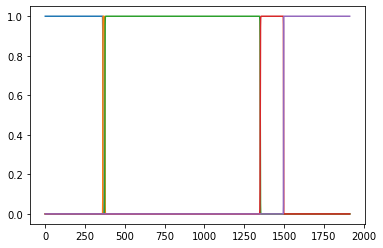

In [40]:
for proba in posterior_table['P25_cam01_P25_sandwich']:
    plt.plot(proba)

In [33]:
print("Calculating Validation Data Accuracy")
correct = 0.0
total = 0.0
for i, item in enumerate(testloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)

        pred = torch.argmax(predictions[-1], dim=1)
        correct += float(torch.sum((pred == item_2) * src_mask).item())
        total += float(torch.sum(src_mask).item())

print(f"Validation:: Probability Accuracy {correct * 100.0 / total}")

Calculating Validation Data Accuracy
Validation:: Probability Accuracy 69.60005698208626


In [107]:
framewise_proba = prob[j].cpu()
ele = item[4][j]
frame_count = frame_id_dict[ele]
label_list = [label_name_to_label_id_dict[item] for item in weak_labels[ele]]
seqlen = len(label_list)
label_seq_prob = framewise_proba[:frame_count,label_list]
label_seq_logprob = torch.log(label_seq_prob + 1e-10)

left_probsum = torch.cumsum(label_seq_prob, dim=1)
right_probsum = torch.sum(label_seq_prob, dim=1, keepdim=True) - torch.cumsum(label_seq_prob, dim=1) + label_seq_prob

left_logprobsum = torch.log(torch.clip(left_probsum, min=1e-20))
right_logprobsum = torch.log(torch.clip(right_probsum, min=1e-20))

left_logprobsum_left_idsum = torch.cumsum(left_logprobsum, dim=0)
left_logprobsum_left_idsum -= left_logprobsum
right_logprobsum_right_idsum = torch.sum(right_logprobsum, dim=0, keepdim=True) - torch.cumsum(right_logprobsum, dim=0)

for k in range(seqlen):
    left_logprobsum_left_idsum[:k,k] = -1000
    remaining_labelcount = seqlen-k-1
    if remaining_labelcount > 0:
        right_logprobsum_right_idsum[-remaining_labelcount:,k] = -1000

loglikelihood = label_seq_logprob + left_logprobsum_left_idsum + right_logprobsum_right_idsum
posterior = loglikelihood.T + torch.log(torch.clip(torch.tensor(prior_table[ele]), min=1e-10))
posterior = torch.softmax(posterior, dim=0)

In [116]:
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        for j in range(len(prob)):
            generate_posterior_loss_weights(prob[j].cpu(), item[4][j])

        if i%10==0:
            print(f'{i+1} iteration done')
get_boundary_err()

1 iteration done
11 iteration done
21 iteration done
31 iteration done
41 iteration done
51 iteration done
61 iteration done
71 iteration done
81 iteration done
91 iteration done
101 iteration done
111 iteration done
121 iteration done
131 iteration done
141 iteration done
151 iteration done
161 iteration done
171 iteration done
181 iteration done
Train Boundary avergage error = 118.393
